[INFO] Loading TwinMarket belief log: /Users/abhayatrivedi/Documents/projects/twinmark/util/belief/belief_1000.csv
Columns: Index(['user_id', 'belief', 'attitude'], dtype='object')
Training GNN Teacher...
[GNN] Epoch 000 | Loss 1.1163
[GNN] Epoch 050 | Loss 0.5238
[GNN] Epoch 100 | Loss 0.5178
[GNN] Epoch 150 | Loss 0.5170
Distilling → MLP Student
[KD] Epoch 000 | Loss 0.7361
[KD] Epoch 050 | Loss 0.4318
[KD] Epoch 100 | Loss 0.4310
[KD] Epoch 150 | Loss 0.4310
Injecting belief misinformation attack
SYSTEMIC FRAGILITY RESULTS
GNN Volatility: 0.4809
MLP Volatility: 0.3438


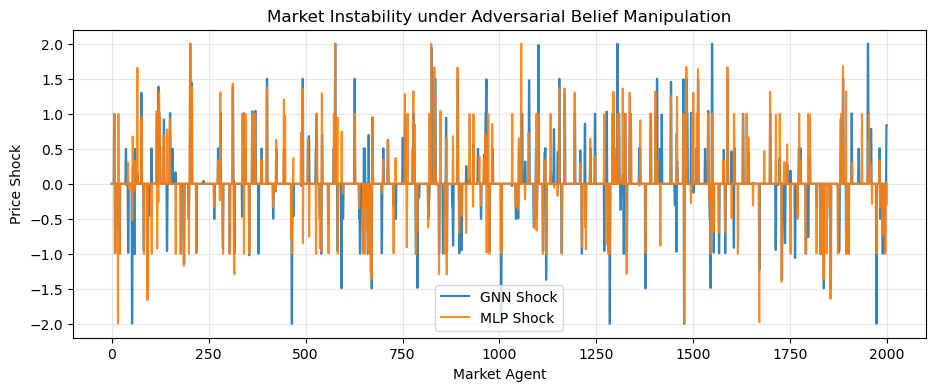

In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch_geometric.nn import GCNConv

# -------------------- CONFIG --------------------

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
np.random.seed(42)

ROOT = "/Users/abhayatrivedi/Documents/projects/twinmark"
BELIEF_PATH = os.path.join(ROOT, "util", "belief", "belief_1000.csv")

EMBED_DIM = 128
NUM_CLASSES = 3
ATTACK_RATIO = 0.15
ATTACK_STRENGTH = 3.0
EPOCHS = 200
LR = 0.005


belief_map = {
    "非常悲观": -1.0,
    "悲观的": -0.6,
    "中性的": 0.0,
    "乐观的": 0.6,
    "非常乐观": 1.0
}

def encode_belief(val):
    if isinstance(val, str):
        return belief_map.get(val.strip(), 0.0)
    return float(val)


print(f"[INFO] Loading TwinMarket belief log: {BELIEF_PATH}")
belief_df = pd.read_csv(BELIEF_PATH)
print("Columns:", belief_df.columns)

# -------------------- BELIEF GRAPH --------------------

def build_belief_graph(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        agent = f"A_{row.iloc[0]}"
        asset = f"S_{row.iloc[1]}"
        belief = encode_belief(row.iloc[2])
        G.add_edge(agent, asset, weight=belief)
    return G

belief_graph = build_belief_graph(belief_df)
node_map = {n: i for i, n in enumerate(belief_graph.nodes())}

edges = []
for u, v in belief_graph.edges():
    edges.append([node_map[u], node_map[v]])
    edges.append([node_map[v], node_map[u]])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous().to(DEVICE)

# -------------------- NODE FEATURES --------------------

def belief_to_features(df, node_map, dim):
    X = torch.zeros(len(node_map), dim)
    for _, row in df.iterrows():
        agent = f"A_{row.iloc[0]}"
        idx = node_map[agent]
        belief = encode_belief(row.iloc[2])
        X[idx] += belief * torch.randn(dim)
    return X

X = belief_to_features(belief_df, node_map, EMBED_DIM).to(DEVICE)
y = torch.randint(0, NUM_CLASSES, (X.shape[0],), device=DEVICE)

# -------------------- MODELS --------------------

class GNNTeacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(EMBED_DIM, 256)
        self.conv2 = GCNConv(256, NUM_CLASSES)

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        return self.conv2(h, edge_index)

class MLPStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(EMBED_DIM, 256)
        self.fc2 = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

# -------------------- ATTACK --------------------

def inject_belief_attack(X, ratio=0.15, strength=3.0):
    n = X.shape[0]
    k = int(ratio * n)
    idx = torch.randperm(n)[:k]
    X_adv = X.clone()
    X_adv[idx] += strength * torch.randn_like(X_adv[idx])
    return X_adv

# -------------------- DISTILLATION --------------------

def distill(teacher, student, X, edge_index, y):
    opt = torch.optim.Adam(student.parameters(), lr=LR)
    for epoch in range(EPOCHS):
        teacher.eval()
        student.train()

        with torch.no_grad():
            t_logits = teacher(X, edge_index)

        s_logits = student(X)

        loss_kd = F.kl_div(
            F.log_softmax(s_logits, dim=1),
            F.softmax(t_logits, dim=1),
            reduction='batchmean'
        )
        loss_sup = F.cross_entropy(s_logits, y)
        loss = 0.7 * loss_kd + 0.3 * loss_sup

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % 50 == 0:
            print(f"[KD] Epoch {epoch:03d} | Loss {loss.item():.4f}")

# -------------------- PRICE SIMULATION --------------------

def simulate_price(logits):
    probs = F.softmax(logits, dim=1)
    return (probs[:, 1] - probs[:, 0]).detach().cpu().numpy()

# -------------------- EXPERIMENT --------------------

teacher = GNNTeacher().to(DEVICE)
opt = torch.optim.Adam(teacher.parameters(), lr=LR)

print("Training GNN Teacher...")

for epoch in range(EPOCHS):
    teacher.train()
    out = teacher(X, edge_index)
    loss = F.cross_entropy(out, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 50 == 0:
        print(f"[GNN] Epoch {epoch:03d} | Loss {loss.item():.4f}")

student = MLPStudent().to(DEVICE)

print("Distilling → MLP Student")
distill(teacher, student, X, edge_index, y)

print("Injecting belief misinformation attack")
X_adv = inject_belief_attack(X, ATTACK_RATIO, ATTACK_STRENGTH)

teacher.eval()
student.eval()

with torch.no_grad():
    gnn_clean = teacher(X, edge_index)
    gnn_adv   = teacher(X_adv, edge_index)
    mlp_clean = student(X)
    mlp_adv   = student(X_adv)

p_gnn_clean = simulate_price(gnn_clean)
p_gnn_adv   = simulate_price(gnn_adv)
p_mlp_clean = simulate_price(mlp_clean)
p_mlp_adv   = simulate_price(mlp_adv)

# -------------------- RESULTS --------------------

print("SYSTEMIC FRAGILITY RESULTS")
print(f"GNN Volatility: {np.std(p_gnn_adv - p_gnn_clean):.4f}")
print(f"MLP Volatility: {np.std(p_mlp_adv - p_mlp_clean):.4f}")

plt.figure(figsize=(11,4))
plt.plot(p_gnn_adv - p_gnn_clean, label="GNN Shock", alpha=0.9)
plt.plot(p_mlp_adv - p_mlp_clean, label="MLP Shock", alpha=0.9)
plt.legend()
plt.title("Market Instability under Adversarial Belief Manipulation")
plt.xlabel("Market Agent")
plt.ylabel("Price Shock")
plt.grid(alpha=0.3)
plt.show()